# Benchmarking Our Algorithm against others

In [2]:
import sys
sys.path.append('../../')
import numpy as np

from panav.viz import draw_env,draw_hybrid
from panav.util import flowtime

import pickle as pkl

%load_ext autoreload
%autoreload 2

In [4]:
results

[{'plan': [(array([-0.     , 30.71672, 39.202  , 57.69991]),
    array([[ 14.  ,   3.  ,  -3.  , -15.75],
           [ 18.  ,  -3.72,  -4.67, -17.75]]))],
  'time': 0.0635838508605957,
  'N_agent': 1,
  'alg_name': 'Seq_Tube',
  'TIMEOUT': 30,
  'env': <panav.environment.env.MultiTunnelEnv at 0x12438ff50>},
 {'plan': [(array([-0.     , 30.71672, 39.202  , 57.69991]),
    array([[ 14.  ,   3.  ,  -3.  , -15.75],
           [ 18.  ,  -3.72,  -4.67, -17.75]]))],
  'time': 0.04560208320617676,
  'N_agent': 1,
  'alg_name': 'Seq_Tube_nonLazy',
  'TIMEOUT': 30,
  'env': <panav.environment.env.MultiTunnelEnv at 0x12438ff50>},
 {'plan': [(array([-0.     , 30.71672, 39.202  , 57.69991]),
    array([[ 14.  ,   3.  ,  -3.  , -15.75],
           [ 18.  ,  -3.72,  -4.67, -17.75]]))],
  'time': 0.04353904724121094,
  'N_agent': 1,
  'alg_name': 'Seq_S2M2',
  'TIMEOUT': 30,
  'env': <panav.environment.env.MultiTunnelEnv at 0x12438ff50>},
 {'plan': [(array([ 0.     , 12.71938, 25.53693, 52.55964, 63.7

In [5]:
performance

{'Seq_Tube': {'n_agents': [1, 11, 21, 31],
  'Compute Time': [0.0635838508605957, 4.358555316925049, 25.453551292419434],
  'Ave. Travel Cost': [57.69991334482228,
   53.438935136613374,
   61.42815956325988]},
 'Seq_Tube_nonLazy': {'n_agents': [1, 11, 21],
  'Compute Time': [0.04560208320617676, 15.209314107894897],
  'Ave. Travel Cost': [57.69991334482228, 52.71342889398416]},
 'Seq_S2M2': {'n_agents': [1, 11, 21, 31],
  'Compute Time': [0.04353904724121094],
  'Ave. Travel Cost': [57.69991334482228]},
 'ST-RRT*': {'n_agents': [1, 11, 21],
  'Compute Time': [0.1031341552734375, 1.486433982849121],
  'Ave. Travel Cost': [86.59188427159496, 55.58790719211268]}}

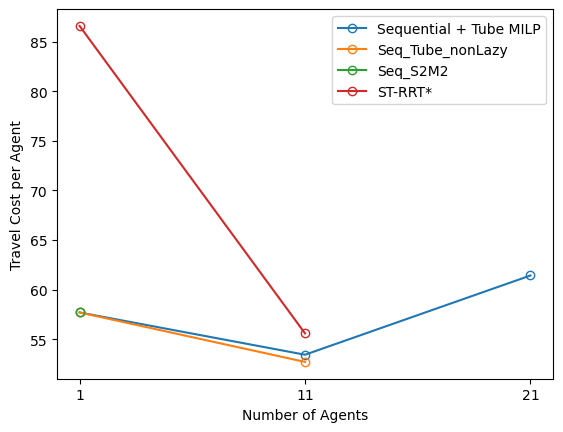

[1, 11, 21, 31]
[1, 11, 21]
[1, 11, 21, 31]
[1, 11, 21]


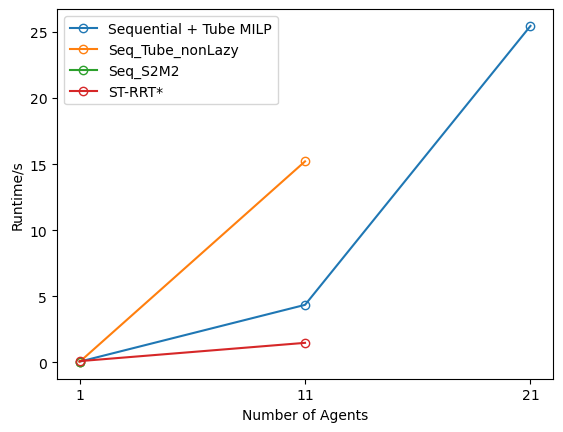

In [20]:
# env_name = "Arena_Mockup"
# env_name = "MultiTunnel_Large"
env_name = "MultiTunnel"
# env_name = "Warehouse"
# env_name = "Room"

# Make the figure saving folder
import os
if env_name not in os.listdir('./figures'):
    os.mkdir("./figures/"+env_name)

# Load data
with open("./data/{}.pkl".format(env_name),'rb') as fp:
    results = pkl.load(fp)


TIMEOUT = 100
# Visualize the simulation results
metrics = {
        #     "Makespan": lambda result: [makespan(result['plan'])] if result['plan'] else [],
        #    "Flowtime": lambda result: [flowtime(result['plan'])] if result['plan'] else [],
        "Compute Time": lambda result: [result['time']] if result['plan'] is not None or result['time']>TIMEOUT else [],
        #    "Throuput per 60s": lambda result: [result['N_agent']/makespan(result['plan']) * 60]  if result['plan'] else [],
           "Ave. Travel Cost": lambda result: [flowtime(result['plan'])/result['N_agent']] if result['plan'] is not None and all([p is not None for p in result['plan']]) else []
           }

legends = {
    "PIBT":"Hybrid Graph + PIBT",
    "S2M2": "S2M2",
    "PBS_Tube": "PBS + Tube MILP",
    "TAHP": "Hybrid Graph + MILP",
    "Seq_Tube": "Sequential + Tube MILP",
    "Seq_Temp_Obs": "Sequential + Simple MILP"
}

noplot = {"Seq_Temp_Obs"}
# noplot = {}

# n_to_display = np.arange(2,21,2)
n_to_display = [10,20,30,40,50,60,70,80,90,100]
# n_to_display = [10,20,30,40,50,60,70]

performance = {}

for result in results:
    # print(result['plan'][-1])
    alg = result['alg_name']

    if alg not in performance:
        performance[alg] = {}
        performance[alg]['n_agents'] = []
    
    performance[alg]['n_agents'].append(result['N_agent'])

    for metric, eval in metrics.items():
        if metric not in performance[alg]:
            performance[alg][metric] = []
        
        performance[alg][metric]+=eval(result)
from matplotlib import pyplot as plt

# Travel Cost per Agent
metric = "Ave. Travel Cost"
plt.figure()
plt.ylabel("Travel Cost per Agent")
plt.xlabel("Number of Agents")
ymax = 0
xticks = set()
for alg in performance:
    if alg in noplot:
        continue
    x = performance[alg]['n_agents']
    # idx = [i for i in range(len(x)) if x[i] in n_to_display]
    # print(x)
    # x = [x[i] for i in idx]

    val = performance[alg][metric]
    # val = [val[i] for i in idx if i<len(val)]
    l = min(len(x),len(val))
    if l>0:
        plt.plot(x[:l],val[:l], label = legends[alg] if alg in legends else alg, marker = "o",markerfacecolor= 'none')
        xticks.update(x[:l])
        ymax = max(ymax,max(val[:l]))



plt.xticks(list(xticks))
# plt.ylim(0.0,ymax*1.04)
plt.legend()
plt.savefig("./figures/"+env_name+"/TravelCost.pdf")
plt.show()


# Computational Time
metric = "Compute Time"
plt.figure()
plt.ylabel("Runtime/s")
plt.xlabel("Number of Agents")
xticks = set()
for alg in performance:
    if alg in noplot:
        continue
    x = performance[alg]['n_agents']
    # idx = [i for i in range(len(x)) if x[i] in n_to_display]
    # x = [x[i] for i in idx]
    print(x)

    val = performance[alg][metric]
    # val = [val[i] for i in idx if i<len(val)]
    l = min(len(x),len(val))
    if l>0:
        plt.plot(x[:l],val[:l], label = legends[alg] if alg in legends else alg, marker = "o",markerfacecolor= 'none')
        xticks.update(x[:l])

plt.xticks(list(xticks))

ymax = TIMEOUT        
# plt.ylim(0.0,ymax*1.0)
plt.legend()
plt.savefig("./figures/"+env_name+"/Runtime.pdf")
plt.show()



In [6]:
from panav.viz import animation,interpolate_positions

from IPython.display import HTML, display
interp_dt = 0.1

pos = []
for cp in continuous_plans:
    _,xs = interpolate_positions(*cp,interp_dt)
    pos.append(xs)

anim = animation(HG.env, pos, bloating_r=0.5, dt = interp_dt / 4)
anim.save("./figures/"+env_name+"/demo.mp4")
anim.save("./figures/"+env_name+"/demo.gif")
plt.close()   # Avoid plotting an extra figure.